# Translated - Machine Learning Assessment - Exercise 1
Author: Christian Brignone (brignonechristian@gmail.com)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay

### Data Loading and Visualization

In order to build our language classifier we first need to have access to the [dataset](https://www.kaggle.com/datasets/basilb2s/language-detection?resource=download). We may proceed in different ways, for example, we may directly download the data from Kaggle by using an API Token as described [here](https://www.kaggle.com/general/74235) or upload the dataset in our Google Drive and then mount the drive in the Colab workspace. Since the dataset is very small (1.91MB), the easiest and fastest way to use the data is by downloading and then manually uploading the dataset in the Colab runtime from [here](https://www.kaggle.com/datasets/basilb2s/language-detection?resource=download).

Once we have the dataset archive **Detection.csv.zip** at our disposal in the runtime, we can extract the **.csv** file and build a *pandas* dataframe to simplify the data handling and visualization.

In [2]:
# Extract the dataset in the "dataset" folder
!unzip Language\ Detection.csv.zip -d dataset 

"unzip" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [2]:
# Build a Pandas dataframe from the .csv file
df=pd.read_csv('dataset/Language Detection.csv') 

In [3]:
# Display the first five rows of the dataframe
df.head() 

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


As we can see from the first rows of the dataframe, many of the sentences contain special characters that, later on, must be removed to obtain better classification performance.

To have a clearer picture of the data distribution, we can plot a histogram describing the total number of senteces for each language.

<Axes: xlabel='Language'>

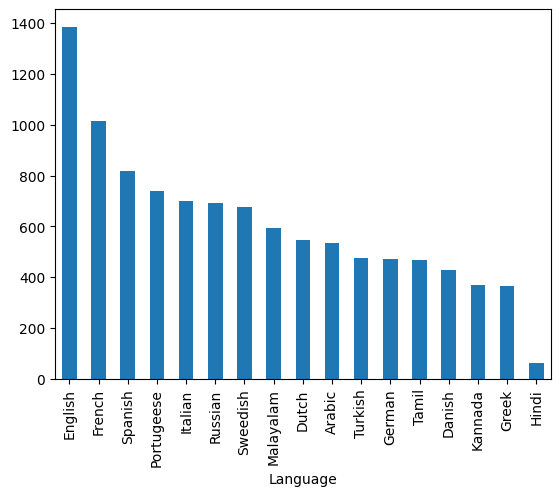

In [4]:
df['Language'].value_counts().plot(kind='bar')

Since our task consists in the binary classification of italian vs not italian sentences, the dataset must be modified consequently.

<Axes: xlabel='Language'>

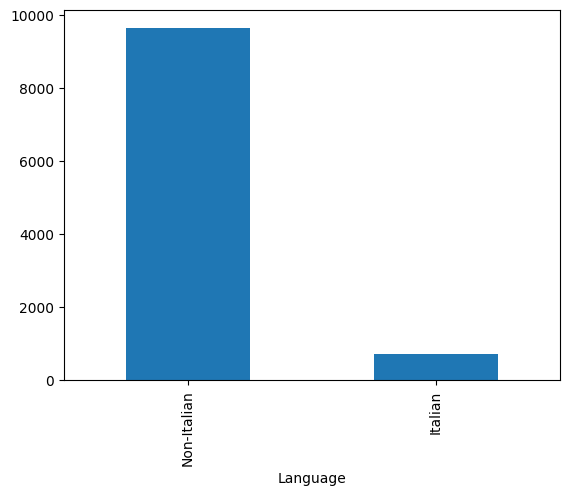

In [5]:
# Substitute each Non-Italian language with the label 'Non-Italian'
df['Language']=df['Language'].apply(lambda x : x if x=='Italian' else 'Non-Italian') 
df['Language'].value_counts().plot(kind='bar')

In [6]:
# Compute percentage dataset distribution
df['Language'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%' 

Language
Non-Italian    93.2%
Italian         6.8%
Name: proportion, dtype: object

We are dealing with a highly imbalanced dataset, in fact, Italian sentences only represent 6.8% of the total. This means that in the evaluation of the model's performances, we need to use specific evaluation metrics like *precision*, *recall* and *F1-score*; otherwise, relying only on the accuracy of the model, we may get a relatively good accuracy (0.93) by predicting each sentence as 'Non-Italian', thus without correctly learning the task.

### Data Preprocessing

Now we will preprocess the data by removing special characters and we will organize the data in two lists, X for the Text and y for the labels. For this task, differently from classical NLP problems, we will not employ stemming or lemmatization, since by removing suffixes to get to the root form of a word, we may get the same root form from words belonging to different languages, thus losing important information for the classification process.

In [7]:
# Remove special characters and uppercase
X=df['Text'].apply(lambda x: re.sub(r'[!@#$(),\n"%^\*\?\:;~`0-9\.\[\]\+\-\'=£]', '', x.lower()) ) 

# Transform the dataframe in a list of samples
X=X.tolist()

# Substitute 'Italian' with 1 and 'Non-Italian' with 0 to have a binary encoding of the labels
y=df['Language'].apply(lambda x : 1 if x=='Italian' else 0)

# Transform the dataframe in a list of labels
y=y.tolist() 


We split the dataset in train-set and test-set, in particular we will use 80% of the dataset for training and 20% for testing. To make the experiment reproducible we set the random state in the train_test_split function.

In [8]:
# Fix the seed to make the experiment reproducible
seed=10

# Dataset splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed) 

### Model selection and fitting

Finally, we define a pipeline which will handle the tokenization, vectorization and classification of the sentences.

Since we are dealing with a relatively easy task and we have a small dataset, we will avoid heavy transformer-based solutions and we will instead rely on classical machine learning classification algorithms like Naive Bayes, Support Vector Machine or Logistic Regression which guarantee high accuracy while requiring very low computational resources. 

In order to determine the best combination of tokenizer, vectorizer and classifier, we perform a grid search on various algorithms and their hyperparameters. 
In particular, we employ: 

- **CountVectorizer**: applies a word-level tokenization considering both unigrams and bigrams and a vectorization which produces a sparse representation of token counts.
- **TfidfVectorizer**: applies a word-level tokenization considering both unigrams and bigrams and a vectorization that weights the word counts by a measure of how often they appear in the documents.

- **Naive Bayes**: under the assumption that the input features are independent of each other, compute the probabilities of a new instance belonging to each class and select the class with the highest probability as the predicted class. We will compare the *MultinomialNB* and *ComplementNB* (designed to address the problem of imbalanced dataset) variants for different values of the parameter *alpha*, used to specify the smoothing factor for the probability estimates (small values of alpha results in more aggressive smoothing, whereas large values of alpha results in less smoothing).
- **Support Vector Classification (SVC)**: finds the hyperplane that best separates the data points of different classes. We will use *linear* and *rbf* kernels, different values for *C* which controls the trade-off between the margin size and the training error and different class weights to mitigate the skewed dataset problem.
- **LogisticRegression**: assuming that the relationship between the features and the output is linear, it models the probability of a new instance belonging to a particular class using a logistic function. Also in this case we will test different values for the parameter *C* which controls the regularization strength and different class weights.

All the combinations of vectorizers, classifiers and hyperparameters will be fitted on the dataset and evaluated through a 5-fold cross validation and, finally, the model achieving the best F1-score will be used for our application.



In [9]:
# Define a pipeline with the vectorizer and model to test
pipelines =  Pipeline([
        ('vect', None),
        ('clf', None)
    ])

# Define the parameter grid for the pipeline
param_grids =[
    {
        'vect': [CountVectorizer(), TfidfVectorizer()],
        'vect__ngram_range': [(1,1), (1,2)],
        'clf': [MultinomialNB(), ComplementNB()],
        'clf__alpha': [0.1, 0.5, 1]
    },
    {
        'vect': [CountVectorizer(), TfidfVectorizer()],
        'vect__ngram_range': [(1,1), (1,2)],
        'clf': [SVC(random_state=seed)],
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf'],
        'clf__class_weight': [None,'balanced']
    },
    {
        'vect': [CountVectorizer(), TfidfVectorizer()],
        'vect__ngram_range': [(1,1), (1,2)],
        'clf': [LogisticRegression(random_state=seed)],
        'clf__C': [0.1, 1, 10],
        'clf__class_weight': [None,'balanced']
    }
]

# Create a GridSearchCV object with the pipeline and parameter grids, n_jobs=-1 allows parallel processing
grid_search = GridSearchCV(estimator=pipelines, param_grid=param_grids, cv=5, scoring='f1', n_jobs=-1)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best F1-score: ", round(grid_search.best_score_,3))

# Select the best model from the GridSearchCV object
model=grid_search.best_estimator_

Best parameters:  {'clf': MultinomialNB(alpha=0.1), 'clf__alpha': 0.1, 'vect': CountVectorizer(ngram_range=(1, 2)), 'vect__ngram_range': (1, 2)}
Best f1-score:  0.9829823219289976


### Tests and results

After the model fitting, we can test the performance of the classifier on the test split.

In [11]:
# Prediction on test split
y_pred = model.predict(X_test) 

In order to evaluate the performance of the model, as previously mentioned, since we are dealing with a skewed dataset we should not rely only on the *accuracy* metric to of the model to assess its capabilities but we also need *precision*, *recall* and *F1-score*.

In particular, *precision* measures the proportion of true positive predictions among all positive predictions made by the model while *recall* measures the proportion of true positive predictions among all actual positive instances in the dataset. The *F1-score* is the harmonic mean of precision and recall and especially for a skewed dataset, it can be used as a global indicator of the model's performances as it provides a good balance between *precision* and *recall*.

To have a clearer idea of the model's capabilities we also plot the confusion matrix.

              precision    recall  f1-score   support

 Non-Italian      0.999     0.999     0.999      1928
     Italian      0.993     0.993     0.993       140

    accuracy                          0.999      2068
   macro avg      0.996     0.996     0.996      2068
weighted avg      0.999     0.999     0.999      2068

F1-score: 0.993


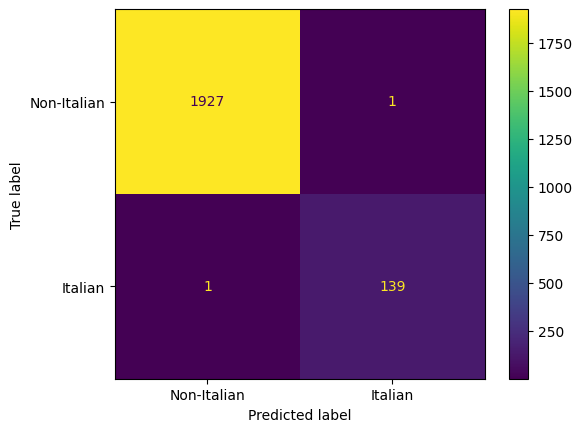

In [12]:
# Compute the evaluation metrics
clf_report = classification_report(y_test, y_pred, target_names=['Non-Italian','Italian'], digits=3)
print(clf_report)

#
print('F1-score: ' + str(round(f1_score(y_test, y_pred),3)))

# Compute the Confusion Matrix
confusion_matrix = confusion_matrix(y_test, y_pred)

# Plot of the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=['Non-Italian','Italian'])
disp.plot()
plt.show()

By analyzing the test results it is possible to see that the model correctly learned the task, in fact, the most significant metric, the *F1-score*, is equal to 0.993 which translates into almost perfect predictions, only 2 of the 2068 test samples have been miss-classified.

### Save model

Now our model is ready to be used for inference, therefore we need to export it in order to be later used in the REST API   

In [15]:
# Save model using pickle
filename = 'language_detection_model.pkl'
pickle.dump(model, open(filename, 'wb'))